# Empirical Application 3 Financial Econometrics

*By Daniel Deutsch, José Lucas Barretto, and Stéphane Roblet*

In [ ]:
import warnings

import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import display
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen, select_order

In [ ]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Importing Data

In [8]:
# Import data
df_aaa = pd.read_csv("./datasets/aaa.csv", names=['date', 'valueaaa'], parse_dates=['date'], skiprows=[0], na_values='.')
df_govbonds = pd.read_csv("./datasets/govbonds.csv", names=['date', 'valuegov'], parse_dates=['date'], skiprows=[0], na_values='.')
df_sp500 = pd.read_csv("./datasets/sp500.csv", names=['date', 'logS&P500'], parse_dates=['date'], skiprows=[0], na_values='.')

# Ignore day in datetime
df_aaa['date'] = df_aaa['date'].astype('datetime64[M]')
df_govbonds['date'] = df_govbonds['date'].astype('datetime64[M]')
df_sp500['date'] = df_sp500['date'].astype('datetime64[M]')

# Drop duplicates
df_aaa.drop_duplicates('date', inplace=True, ignore_index=True)
df_govbonds.drop_duplicates('date', inplace=True, ignore_index=True)
df_sp500.drop_duplicates('date', inplace=True, ignore_index=True)

# Remove not available data
df_aaa.dropna(inplace=True)
df_govbonds.dropna(inplace=True)
df_sp500.dropna(inplace=True)

# Applies log-transform
df_sp500["logS&P500"] = np.log(df_sp500['logS&P500'])

# Merges
df = pd.merge(df_aaa[['date', 'valueaaa']], df_govbonds[['date', 'valuegov']], on='date', how='inner').rename(columns={ 'diff_x': 'diff_aaa', 'diff_y': 'diff_govbonds' })
df = df.merge(df_sp500[['date', 'logS&P500']], on='date', how='inner').rename(columns={ 'diff': 'diff_sp500' })
df.set_index('date', inplace=True)
df

,valueaaa,valuegov,logS&P500
date,,,
1983-01-01,11.77,10.46,1.562346
1983-02-01,12.03,10.72,1.547563
1983-03-01,11.64,10.51,1.515127
1983-05-01,11.35,10.38,1.439835
1983-06-01,11.78,10.85,1.427916
...,...,...,...
2021-03-01,2.85,1.61,0.385262
2021-04-01,2.91,1.64,0.329304
2021-05-01,2.92,1.62,0.329304


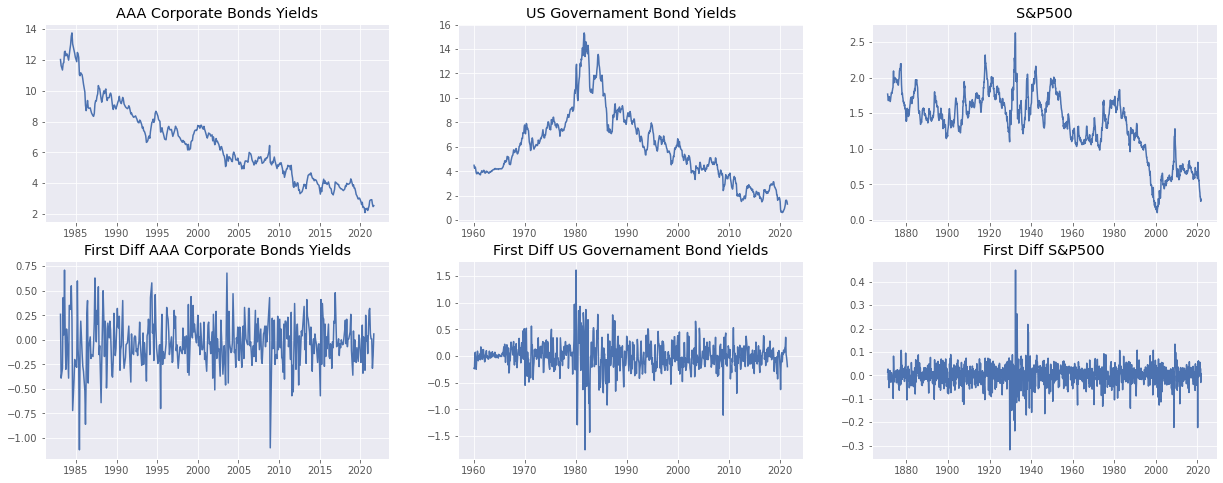

In [9]:
# Hypothesis =  linear trend
# We select a lag of 1 
jres = coint_johansen(df, det_order=1, k_ar_diff=1)

# The cointegration rank is equal to 0.
# The result is the same wether we are considering the eigenvalue statistic or the trace statistic.
# None of the series can help improving the prediction of one of the series.
# None of the series is causal (in a Granger sense)
# Therefore, we need to estimate a VAR in first differences. 

# Obtains the first difference
df_aaa['diff'] = df_aaa['valueaaa'].diff()
df_govbonds['diff'] = df_govbonds['valuegov'].diff()
df_sp500['diff'] = df_sp500['logS&P500'].diff()

# Remove not available data
df_aaa.dropna(inplace=True)
df_govbonds.dropna(inplace=True)
df_sp500.dropna(inplace=True)

# Plot the original series and it's first difference
fig, axs = plt.subplots(2, 3, figsize=(21, 8))
axs[0, 0].plot(df_aaa['date'], df_aaa['valueaaa'])
axs[0, 0].set_title("AAA Corporate Bonds Yields")
axs[1, 0].plot(df_aaa['date'], df_aaa['diff'])
axs[1, 0].set_title("First Diff AAA Corporate Bonds Yields")
axs[0, 1].plot(df_govbonds['date'], df_govbonds['valuegov'])
axs[0, 1].set_title("US Governament Bond Yields")
axs[1, 1].plot(df_govbonds['date'], df_govbonds['diff'])
axs[1, 1].set_title("First Diff US Governament Bond Yields")
axs[0, 2].plot(df_sp500['date'], df_sp500['logS&P500'])
axs[0, 2].set_title("S&P500")
axs[1, 2].plot(df_sp500['date'], df_sp500['diff'])
axs[1, 2].set_title("First Diff S&P500")
plt.show()

In [10]:
dfVAR = pd.merge(df_aaa[['date', 'diff']], df_govbonds[['date', 'diff']], on='date', how='inner').rename(columns={ 'diff_x': 'diff_aaa', 'diff_y': 'diff_govbonds' })
dfVAR = dfVAR.merge( df_sp500[['date', 'diff']], on='date', how='inner').rename(columns={ 'diff': 'diff_sp500' })
dfVAR.set_index('date', inplace=True)
dfVAR

,diff_aaa,diff_govbonds,diff_sp500
date,,,
1983-02-01,0.26,0.26,0.032435
1983-03-01,-0.39,-0.21,0.035798
1983-05-01,-0.29,-0.02,0.011919
1983-06-01,0.43,0.47,0.000000
1983-07-01,0.05,0.53,-0.030699
...,...,...,...
2021-03-01,0.32,0.35,0.055959
2021-04-01,0.06,0.03,0.000000
2021-05-01,0.01,-0.02,0.014493


In [11]:
df_scores = pd.DataFrame()
best_fit = None
for p in range(10):
    model = VAR(dfVAR)
    model_fit = model.fit(p)
    df_scores = df_scores.append({
        'order': p,
        'AIC': model_fit.aic,
        'BIC': model_fit.bic, 
        'FPE': model_fit.fpe, 
        'HQIC': model_fit.hqic
    }, ignore_index=True)
    best_fit = model_fit if p == 0 else model_fit if model_fit.aic < best_fit.aic else best_fit
    
display(df_scores)
print(f"\nFrom the results shown above we can see that the model that uses {best_fit.k_ar} lags is the optimal one.\n")

best_fit.summary()

,order,AIC,BIC,FPE,HQIC
0,0.0,-12.717593,-12.688099,0.000003,-12.705922
1,1.0,-13.220161,-13.101965,0.000002,-13.173386
2,2.0,-13.261691,-13.054466,0.000002,-13.179675
3,3.0,-13.247781,-12.951196,0.000002,-13.130387
4,4.0,-13.216512,-12.830237,0.000002,-13.063602
5,5.0,-13.204553,-12.728253,0.000002,-13.015987
6,6.0,-13.191945,-12.625284,0.000002,-12.967584
7,7.0,-13.159257,-12.501896,0.000002,-12.898959
8,8.0,-13.134657,-12.386257,0.000002,-12.838281
9,9.0,-13.113039,-12.273258,0.000002,-12.780442



From the results shown above we can see that the model that uses 2 lags is the optimal one.



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Oct, 2021
Time:                     20:50:12
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -13.0545
Nobs:                     406.000    HQIC:                  -13.1797
Log likelihood:           984.856    FPE:                1.73990e-06
AIC:                     -13.2617    Det(Omega_mle):     1.65293e-06
--------------------------------------------------------------------
Results for equation diff_aaa
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.012891         0.009679           -1.332           0.183
L1.diff_aaa             -0.491332         0.058656           -8.376           0.000
L1.diff_govbonds         0.759264         0.0